In [1]:
##%matplotlib widget

import os, time, sys
import importlib
import tables as tb
import matplotlib.pyplot as plt
import numpy as np
import clicfast2023.clicfast2023 as clicfast2023
import clicfast2023.analysis.interpreter as interpreter
import clicfast2023.analysis.event_builder as event_builder
import clicfast2023.analysis.fitfunctions as fitfunctions

# if False:
!ping -c 1 192.168.10.16
if True:
    import clicfast2023.clicfast2023 as clicfast2023
    dut = clicfast2023.Clicfast2023()
    dut.init()
    en_comp = np.copy(dut.PixelConf['en_comp'])
    tdac = np.copy(dut.PixelConf['tdac'])

PING 192.168.10.16 (192.168.10.16) 56(84) bytes of data.
64 bytes from 192.168.10.16: icmp_seq=1 ttl=64 time=0.091 ms

--- 192.168.10.16 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 0.091/0.091/0.091/0.000 ms


2024-06-21 11:53:08,754 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing spi_inj (firmware version: 2), module basil.HL.spi, base_addr 0x10
2024-06-21 11:53:08,755 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing inj (firmware version: 1), module clicfast2023.pulse_gen_delay, base_addr 0x100
2024-06-21 11:53:08,756 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing sync (firmware version: 3), module basil.HL.pulse_gen, base_addr 0x140
2024-06-21 11:53:08,756 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing gate (firmware version: 3), module basil.HL.pulse_gen, base_addr 0x180
2024-06-21 11:53:08,756 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing ts_inj (firmware version: 2), module basil.HL.timestamp, base_addr 0x1c0
2024-06-21 11:53:08,757 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing gpio (firmware version: 0), module basil.HL.gpio, base_addr 0x

### configure Clicfast2023

In [2]:
dut.set_conf(VDACTh=0x70,    #=0x80,(colsmall)
             VDACBL=0x8C, #0x8C,
             BLResP=5,
             VP1=10,
             VP2=10,
             VNComp = 40,
             IPBigFine=8,
             IPSmallFine=8,
             IPFoll=10,
             IPDAC=63,
             NFB2=5, # default=10, tuned at 5
             PFB1=5, # default=10, tuned at 5
             IPRegCasc=5, #defualt=10, tuned at 5
             VNRegC=5, # default=10 tuned at 5 INRegCasc in simulation
             VDACCascN=160,   #106 750mV
             VDACCascP=120,   #120, ##114 800mV in simulation
             Invert=0)

colsmall = np.array([0+3, 4+0, 4+3, 8+0, 8+3, 12+0, 12+3, 16+0, 16+3, 20+0, 20+3, 24+0, 24+3])
collarge = np.array([1, 0+2, 4+1, 4+2, 8+1, 8+2, 12+1, 12+2, 16+1, 16+2, 20+1, 20+2, 24+1, 24+2])
col = 13
comp = 0
delay = 10
dut.set_sync(auto_sync=True)
dut.set_inj(inj_n=0, inj_delay=1024*8-delay, inj_width=1024*8-delay, ext=True)
dut.set_inj_phase(5)

dut.set_inj_amp(0.125, unit="V")
#dut.inject_trig()
dut.inject()
dut.set_en_ampout([col])
dut.set_en_inj(col)
dut.set_en_hitbus([])

dut.PixelConf['en_comp'][:, :] = 0xFF
en_comp = np.copy(dut.PixelConf['en_comp'])
en_comp[:, :] = 0
en_comp[col, :] = 1  ## enable all comp
#dut.PixelConf['tdac'][:, :] = 0xFF
tdac = np.copy(dut.PixelConf['tdac'])
tdac[:, :] = 7
#tdac[colsmall, :] = 7  ## enable all comp
dut.set_ram(en_comp=en_comp, tdac=tdac)

2024-06-21 11:53:10,781 - root - [INFO    ] (MainThread) set_conf:VDACTh=112VDACBL=140BLResP=5VP1=10VP2=10VNComp=40IPBigFine=8IPSmallFine=8IPFoll=10IPDAC=63NFB2=5PFB1=5IPRegCasc=5VNRegC=5VDACCascN=160VDACCascP=120Invert=0
2024-06-21 11:53:10,883 - root - [INFO    ] (MainThread) set_sync: sync_period=0x1000000 repeat=0 auto-sync=1 manual-sync=0
2024-06-21 11:53:10,885 - root - [INFO    ] (MainThread) set_inj: inj_width=8182 inj_delay=8182 inj_n=0 ext=1
2024-06-21 11:53:10,886 - root - [INFO    ] (MainThread) set_phase: width=0x2fec delay=0x1000 phase=5
2024-06-21 11:53:10,887 - root - [INFO    ] (MainThread) inj_amp: 738
2024-06-21 11:53:10,892 - root - [INFO    ] (MainThread) set_en_ampout: en_ampout_col=0x00002000
2024-06-21 11:53:10,897 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00002000
2024-06-21 11:53:10,902 - root - [INFO    ] (MainThread) set_en_hitbus: en_hitbus_col=0x1fffffff
2024-06-21 11:53:10,912 - root - [INFO    ] (MainThread) set_ram row0 en_comp[0 0

### start rx

In [12]:
dut.set_inj(inj_n=100, inj_delay=1024*8+delay, inj_width=1024*8-delay, ext=True)
dut.set_triginj(inj_n=10, inj_delay=(1024*8+delay)*4, inj_width=(1024*8+delay)*4, ext=False)

dut.inject()
dut.inject_trig()
dut.set_rx(False)
time.sleep(1)
dut.set_sync(auto_sync=True)
dut.set_ts_trig(True)
dut.set_ts_inj(True)
dut.set_rx(True, edge=0)

2024-06-11 16:26:45,418 - root - [INFO    ] (MainThread) set_inj: inj_width=8182 inj_delay=8202 inj_n=100 ext=1
2024-06-11 16:26:45,420 - root - [INFO    ] (MainThread) set_triginj: trig_width=32808 trig_delay=32808 trig_n=10 ext=0
2024-06-11 16:26:46,522 - root - [INFO    ] (MainThread) set_sync: sync_period=0x1000000 repeat=0 auto-sync=1 manual-sync=0
2024-06-11 16:26:46,523 - root - [INFO    ] (MainThread) set_ts_trig:1
2024-06-11 16:26:46,523 - root - [INFO    ] (MainThread) set_ts_inj:1
2024-06-11 16:26:46,524 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(332604), try to discard the data...
2024-06-11 16:26:46,667 - root - [INFO    ] (MainThread) set_rx: FPGA alined: aligned=1


### set TDAC highest and find the lowest global threshold


In [13]:
dut.set_conf(VDACTh=0x68)
en_comp[collarge,:] = 1
tdac[:, :] = 7
dut.set_ram(en_comp=en_comp, tdac=tdac)

importlib.reload(interpreter)
dut.mask_rx(False)
time.sleep(1)
raw=dut.get_data_now()
dut.mask_rx(True)
hit, ts, ts_trig =interpreter.raw2list(raw)
len(raw), len(hit), len(ts), len(ts_trig),  np.unique(hit[['col','comp']])

2024-06-11 16:26:48,917 - root - [INFO    ] (MainThread) set_conf:VDACTh=104
2024-06-11 16:26:48,928 - root - [INFO    ] (MainThread) set_ram row0 en_comp[0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0] tdac[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7] wr_0,111,00001_1,111,00000_1,111,00000_0,111,00000_0,111,00000_1,111,00000_1,111,00000_0,111,00000_0,111,00000_1,111,00000_1,111,00000_0,111,00000_0,111,00000_1,111,00000_1,111,00000_0,111,00000_0,111,00000_1,111,00000_1,111,00000_0,111,00000_0,111,00000_1,111,00000_1,111,00000_0,111,00000_0,111,00000_1,111,00000_1,111,00000_0,111,00000_0,111,00000
2024-06-11 16:26:48,938 - root - [INFO    ] (MainThread) set_ram row1 en_comp[0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0] tdac[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7] wr_0,111,00010_1,111,00000_1,111,00000_0,111,00000_0,111,00000_1,111,00000_1,111,00000_0,111,00000_0,111,00000_1,111,00000_1,111,00000_0,111,00000_0,111,00000_1,111,00000

(20,
 4,
 0,
 0,
 array([(2,  0), (2,  8), (2, 10), (2, 11)],
       dtype={'names': ['col', 'comp'], 'formats': ['u1', '<u2'], 'offsets': [8, 9], 'itemsize': 21}))

### inj_scan at the highest TDAC setting

In [15]:
import importlib
import clicfast2023.scans.th_search as th_search
importlib.reload(th_search)
scan = th_search.ThSearch(dut=dut)
fraw = scan.start(inj=[0.015, 0.025, 0.8],
                  #tdac=[7, 6, 5, 4, 3, 2, 1, 0],
                  cols=collarge,
                  comps=None,
                  disable_noninjected_pixel=True,
                  run_mode='auto',
                  n_finalize=3,
                  plsgen='inj')

2024-06-11 16:28:57,998 - root - [INFO    ] (MainThread) Initializing ThSearch
2024-06-11 16:28:57,998 - root - [INFO    ] (MainThread) Scan start time: 2024-06-11_16:28:57
2024-06-11 16:28:58,019 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-06-11 16:28:58,173 - root - [INFO    ] (MainThread) set_rx: FPGA alined: aligned=1
2024-06-11 16:28:58,174 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 48
/home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/clicfast2023/scans/th_search.py:135: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  param_dtype = np.dtype(param_dtype)
2024-06-11 16:28:58,476 - root - [INFO    ] (MainThread) Received words: 0
2024-06-11 16:28:58,477 - root - [INFO    ] (MainThread) Data queue size: 0
2024-06-11 16:28:58,477 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-06-1

## set inj_amp at the threshold (in Vinj) of the lowest pixel

In [16]:
dut.set_inj_amp(0.1, unit="V")
import importlib
import clicfast2023.scans.tdac_tune as tdac_tune
importlib.reload(tdac_tune)
scan = tdac_tune.TdacTune(dut=dut)
fraw = scan.start(
                  cols=collarge, #np.arange(1, dut.ncols,dtype='int'),
                  comps=None,
                  disable_noninjected_pixel=True,
                  run_mode='auto',
                  hitth=0.05,
                  plsgen='inj')

2024-06-11 16:45:32,702 - root - [INFO    ] (MainThread) inj_amp: 583
2024-06-11 16:45:32,703 - root - [INFO    ] (MainThread) Initializing TdacScan
2024-06-11 16:45:32,703 - root - [INFO    ] (MainThread) Scan start time: 2024-06-11_16:45:32
2024-06-11 16:45:32,723 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-06-11 16:45:32,876 - root - [INFO    ] (MainThread) set_rx: FPGA alined: aligned=1
2024-06-11 16:45:32,877 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
/home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/clicfast2023/scans/tdac_tune.py:122: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  param_dtype = np.dtype(param_dtype)
2024-06-11 16:45:33,179 - root - [INFO    ] (MainThread) Received words: 0
2024-06-11 16:45:33,180 - root - [INFO    ] (MainThread) Data queue size: 0
2024-06-11 16:

array([4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 1, 4, 7, 7, 7, 7, 7, 6, 7, 6, 7, 7,
       7, 7, 1, 3, 4, 3, 3, 3, 3, 3, 3, 3, 2, 3, 4, 4, 5, 4, 4, 5, 5, 6,
       4, 4, 4, 5, 1, 1, 1, 0, 1, 0, 2, 2, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 5, 1, 2, 1, 1, 2, 1, 1, 2, 0, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 5, 5, 4, 4, 4, 4, 5, 4, 4, 4, 3, 4,
       4, 4, 4, 5, 4, 4, 4, 4, 5, 4, 1, 2, 2, 1, 0, 2, 2, 1, 1, 0, 2, 0,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 5, 6, 5, 5, 5, 5, 5, 6, 5,
       5, 5, 6, 7, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6], dtype=uint8)

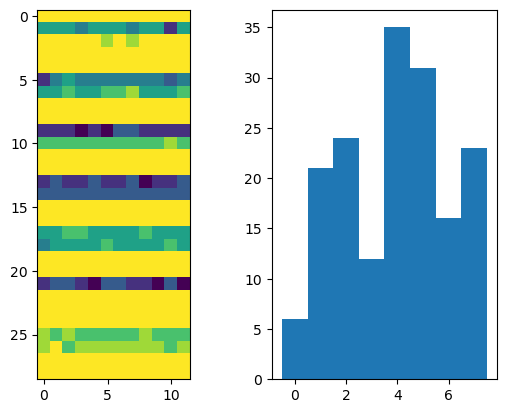

In [51]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(dut.PixelConf['tdac'])
ax[1].hist(dut.PixelConf['tdac'][collarge,:].reshape(-1), bins=np.arange(-0.5, 8.5, 1))
dut.PixelConf['tdac'][collarge,:].reshape([-1])

### threshold distribution after tuning

In [33]:
import importlib
import clicfast2023.scans.th_search as th_search
importlib.reload(th_search)
scan = th_search.ThSearch(dut=dut)
fraw = scan.start(inj=[0.015, 0.025, 0.8],
                  #tdac=[7, 6, 5, 4, 3, 2, 1, 0],
                  cols=collarge,
                  comps=None,
                  disable_noninjected_pixel=True,
                  run_mode='auto',
                  n_finalize=3,
                  plsgen='inj')

2024-06-11 16:59:36,197 - root - [INFO    ] (MainThread) Initializing ThSearch
2024-06-11 16:59:36,197 - root - [INFO    ] (MainThread) Scan start time: 2024-06-11_16:59:36
2024-06-11 16:59:36,217 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-06-11 16:59:36,360 - root - [INFO    ] (MainThread) set_rx: FPGA alined: aligned=0
2024-06-11 16:59:36,361 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 48
2024-06-11 16:59:36,663 - root - [INFO    ] (MainThread) Received words: 0
2024-06-11 16:59:36,664 - root - [INFO    ] (MainThread) Data queue size: 0
2024-06-11 16:59:36,664 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-06-11 16:59:36,665 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-06-11 16:59:36,665 - root - [INFO    ] (MainThread) Discard counter:                0
2024-06-11 16:59:36,665 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-06-11 16:59:36,666 - root - [INFO   

In [35]:
scan.close()

NameError: name 'scan' is not defined

In [ ]:
dut.save_config()